### Desafío - Máquinas de Soporte Vectorial

* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip a la sección correspondiente.

### Descripción
Para esta sesión trabajaremos con la base de datos sobre cáncer mamario de Wisconsin. El objetivo es desarrollar un Clasificador mediante Máquinas de Soporte de Vectores que predizca de forma adecuada en base a una serie de atributos sobre la composición del núcleo de una célula mamaria. Para más detalles técnicos asociados a la base de datos, pueden hacer click en el [link](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names).

### Ejercicio 1: Preparar el ambiente de trabajo
* Importe todas las librerías a utilizar.
* Excluya las columnas id y Unnamed: 32 de la base de datos.
* Recodifique el vector objetivo diagnosis a numérico para poder procesarlo posteriormente.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer

warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize']=(10, 6)

In [2]:
df = pd.read_csv('breast_cancer.csv').drop(columns=['id', 'Unnamed: 32'])
df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis'])
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Ejercicio 2: Visualizando la distribución de los atributos
* Para cada uno de los atributos, grafique los histogramas condicional a cada clase del vector objetivo.
* Agregue las medias correspondientes y reporte a grandes rasgos cuáles son los atributos con una mayor similitud en la distribución.

In [3]:
def graph_hist(df, col_name, group_by):
    """Plots histogram a column grouped by a binary column

    Parameters
    ----------
    df : DataFrame
        DataFrame with data to plot
    col_name : str
        Name of the column you want to plot
    group_by : str
        Name of the binary column used to create plot sets

    Raises
    ------
    NotImplementedError
        Throws this error if the group_by column is not binary
    """
    values = df[group_by].unique()

    if values.size != 2:
        raise NotImplementedError(
            "Only columns with two possible values are supported")

    group_0 = df[df[group_by] == values[0]][col_name].dropna()
    group_1 = df[df[group_by] == values[1]][col_name].dropna()

    def draw(group, group_name, color):
        plt.hist(group, alpha=0.5, color=color, density=True,
                 label='{} {}'.format(group_by, group_name))
        plt.axvline(np.mean(group), color=color)

    draw(group_0, values[0], 'lightblue')
    draw(group_1, values[1], 'tomato')
    plt.title('{} | {}'.format(group_by, col_name))
    plt.legend(loc='best')
    plt.tight_layout()

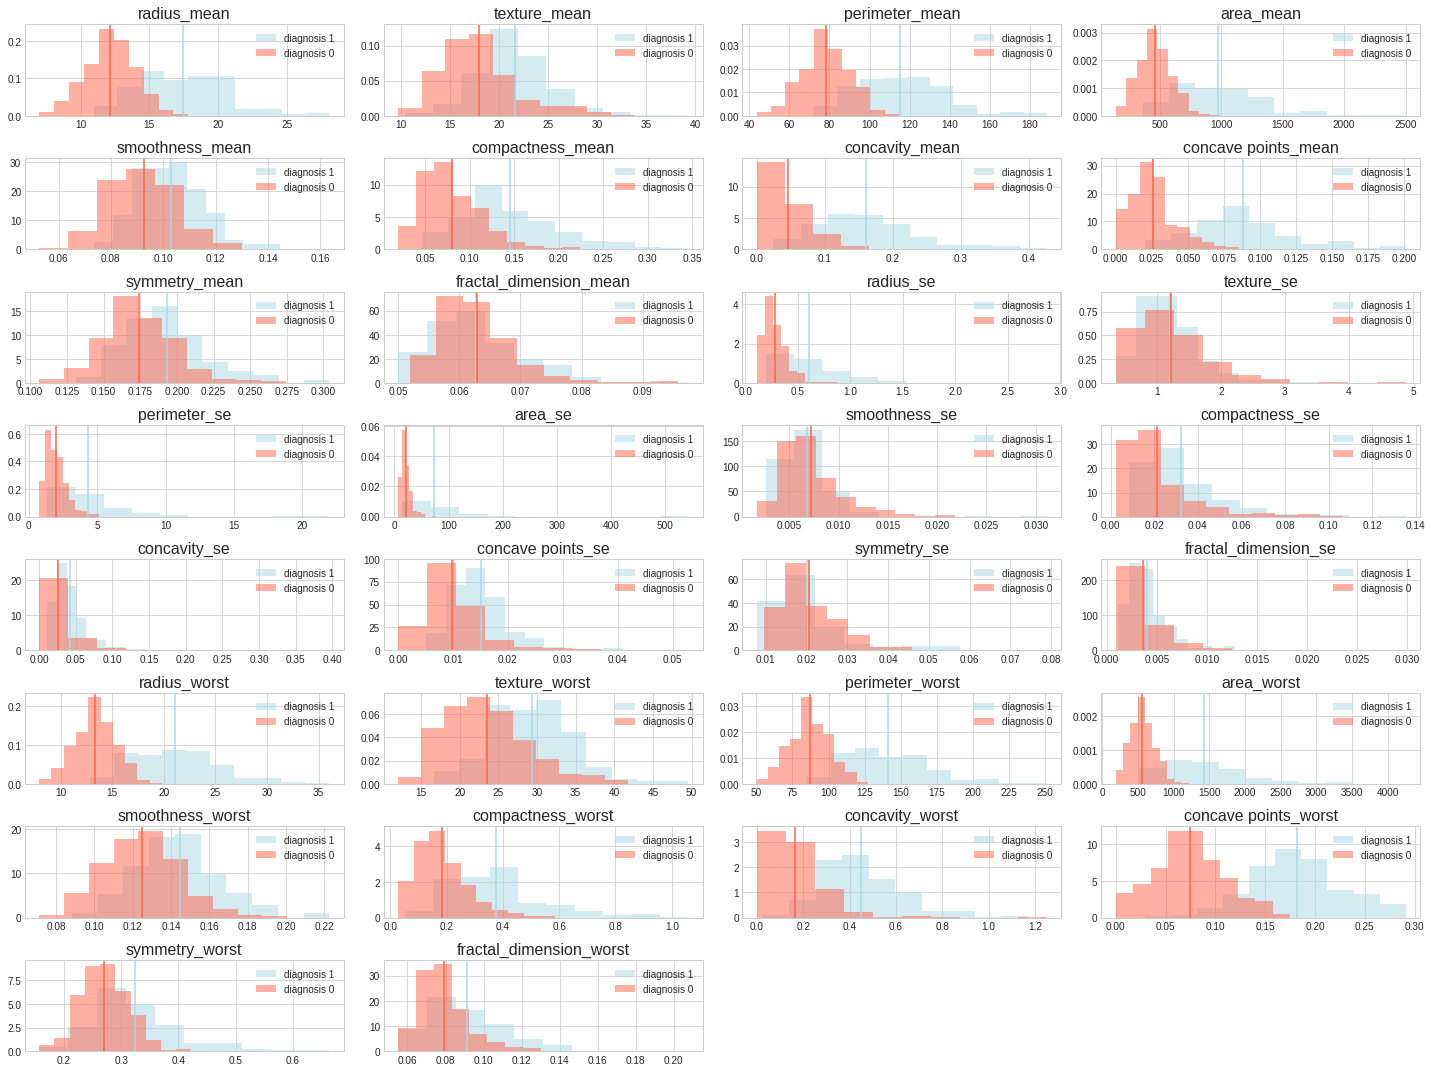

In [4]:
rows = 8
cols = 4

plt.figure(figsize=(20, 15))

for index, (colname, serie) in enumerate(df.loc[:, 'radius_mean':].iteritems()):
    if colname != 'diagnosis':
        plt.subplot(rows, cols, index + 1)
        graph_hist(df, colname, 'diagnosis')
        plt.title(colname, fontsize=16)
        plt.xlabel('')
        plt.ylabel('')
        plt.tight_layout()

A grandes rasgos, los atributos más parecidos en distribución son:
    
- fractal_dimension_mean
- concavity_se
- texture_se
- smoothness_mean
- symmetry_worst

### Ejercicio 3: Estimando el porcentaje de overlap en los atributos
Parte de las virtudes de las Máquinas de Soporte Vectorial es la capacidad de lidiar con clases no separables mediante el proceso de kernelización. Resulta que un aspecto importante que muchas veces se obvía es medir la noseparabilidad de los atributos, condicional a cada clase del vector objetivo.
El procedimiento para estimar el rango de noseparabilidad entre clases se implementa en Python de la siguiente manera:

```python
def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
        # for a specific attribute
        df[df[target] == unique_value][attribute],
        # define percentage
        bins=perc,
        # limit empirical range for comparison
        range=[empirical_lower_bound, empirical_upper_bound]
        )
        # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_-1"])
    intersection = np.true_divide(np.sum(get_minima),
    np.sum(tmp_hist_holder["h_-1"]))
    return intersection
```

* La intersección devolverá el porcentaje de comunalidad entre ambas clases, donde mayores niveles indican una mayor comunalidad.
* Utilizando la función, genere un dataframe donde almacenará el nombre del atributo y su porcentaje. Ordene este dataframe de forma descendente y preserve.

In [5]:
def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
        # for a specific attribute
        df[df[target] == unique_value][attribute],
        # define percentage
        bins=perc,
        # limit empirical range for comparison
        range=[empirical_lower_bound, empirical_upper_bound]
        )
        # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder['h_1'], tmp_hist_holder['h_0'])
    get_maxima = tmp_hist_holder['h_0']
    if np.array_equal(get_minima, tmp_hist_holder['h_0']):
        get_maxima = tmp_hist_holder['h_1']
    intersection = np.true_divide(np.sum(get_minima), np.sum(get_maxima))
    return intersection

In [6]:
overlaps = []

for colname in df.loc[:, 'radius_mean':]:
    overlaps.append(histogram_overlap(df, colname, 'diagnosis'))

overlaps_df = pd.DataFrame(overlaps, index = df.loc[:, 'radius_mean':].columns, columns=['overlap']).sort_values(by='overlap', ascending=False)
overlaps_df

,overlap
fractal_dimension_se,0.593838
smoothness_se,0.591036
fractal_dimension_mean,0.588235
symmetry_se,0.568627
texture_se,0.549020
compactness_se,0.523810
smoothness_mean,0.521008
symmetry_mean,0.509804
concave points_se,0.507003
fractal_dimension_worst,0.492997


### Ejercicio 4: Selección del modelo por GridSearchCV
* Entrene una serie de modelos SVC con los siguientes hiperparámetros:
    C: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] .
    gamma: [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10] .
    Validaciones cruzadas: 10.
* Genere un heatmap en base a los puntajes estimados con GridSearchCV .
    * tip: Vea cómo acceder a la llave mean_test_score en el diccionario cv_results_ .
    
#### Digresión: Un par de elementos a considerar en la implementación de GridSearchCV

Si trabajamos con sklearn.model_selection.GridSearchCV , tan solo haciendo la división en dos muestras es suficiente, incorporando los conjuntos X_train y y_train a nuestro objeto instanciado y preservando X_test e y_test como una muestra de validación externa. Si tenemos un archivo de testing externo, se recomienda no hacer división.
    
   * El objeto creado con sklearn.model_selection.GridSearchCV sigue la misma funcionalidad de cualquier método de estimación de scikit-learn , con los pasos de Instanciar y Entrenar. Este objeto tendrá muchos elementos a considerar:
        * sklearn.model_selection.GridSearchCV.cv_results_ devolverá un diccionario donde las llaves representarán distintas métricas y los valores representarán el desempeño de cada modelo:
            * split* Indicará la métrica específica en cada validacieon cruzada y combinación de hiperparámetros.
            * *_time Indicará el tiempo de ejecución en cada modelo.
        * Por lo general trabajaremos con mean_test_score y mean_train_score que representa la media de CV para cada combinación de hiperparámetros.
        * sklearn.model_selection.GridSearchCV.best_estimator_ devuelve un modelo listo para entrenar con la mejor combinación de hiperparámetros.
        * sklearn.model_selection.GridSearchCV.best_score_ devuelve el desempeño promedio del modelo en el testing interno. Si es un problema de clasificación devolverá Accuracy , si es un problema de regresión devolverá MSE.
        
* Reporte en qué rango de cada hiperparámetro el modelo presenta un desempeño eficiente.
* Reporte la mejor combinación de hiperparámetros y el desempeño en la muestra de entrenamiento.

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

In [8]:
y = df['diagnosis']
X = StandardScaler().fit_transform(df.loc[:, 'radius_mean':])

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.33, random_state = 12082019)

In [9]:
params = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

estimate_cv = GridSearchCV(SVC(kernel='rbf'), params, cv=10)
estimate_cv_result = estimate_cv.fit(X_train, y_train)

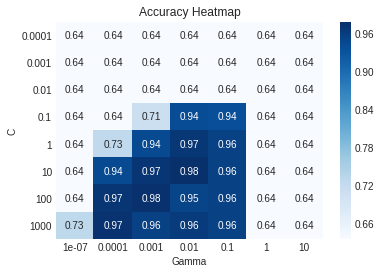

In [10]:
rows = len(params['C']) # 8
cols = len(params['gamma']) # 7
cv_params = estimate_cv_result.cv_results_['mean_test_score'].reshape(rows, cols)
sns.heatmap(cv_params, annot=True, xticklabels=params['gamma'], yticklabels=params['C'], cmap='Blues');
plt.xlabel('Gamma');
plt.ylabel('C');
plt.title('Accuracy Heatmap');

Podemos ver que el mejor rango de hyper parámetros está entre C = 0.1 y C = 1000, Gamma = 0.0001 y Gamma = 0.1

In [11]:
best_estimator = estimate_cv_result.best_estimator_
best_C = best_estimator.C
best_Gamma = best_estimator.gamma

print('La mejor combinación de hiperparámetros es C = {} y Gamma = {}'.format(best_C, best_Gamma))

La mejor combinación de hiperparámetros es C = 10 y Gamma = 0.01


Ahora veremos el desempeño en la muestra de entrenamiento:

In [12]:
from sklearn.metrics import classification_report

y_hat = best_estimator.predict(X_train)
print(classification_report(y_train, y_hat))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       242
           1       1.00      0.97      0.99       139

    accuracy                           0.99       381
   macro avg       0.99      0.99      0.99       381
weighted avg       0.99      0.99      0.99       381



Podemos ver que los resultados son bastante buenos, aunque no hay mucha cantidad de datos.

### Ejercicio 5: Validación del modelo en el hold-out sample
* Genere las predicciones del hold-out sample en base a la mejor combinación de hiperparámetros. 
* Genere un reporte con las métricas de desempeño clásicas para los modelos de clasificación. Comente en qué casos el modelo presenta un desempeño deficiente

In [13]:
y_hat = best_estimator.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       115
           1       0.99      0.95      0.97        73

    accuracy                           0.97       188
   macro avg       0.98      0.97      0.97       188
weighted avg       0.97      0.97      0.97       188



Los resultados son bastante buenos, aunque de los dos casos el peor es la categoría de `malignant` (tumor maligno) ya que el `f1-score` es menor.

### Ejercicio (opcional): Depuración de atributos
* Reentrene el modelo en función de los atributos que presenten un coeficiente de overlap menor a .45.
* Reporte el desempeño del modelo y comente sobre los nuevos hiperparámetros estimados, así como su desempeño en comparación al modelo del ejercicio 5.

Los atributos con menor overlap son los siguientes:

In [14]:
min_overlaps = overlaps_df[overlaps_df['overlap'] < 0.45].index
min_overlaps

Index(['symmetry_worst', 'texture_mean', 'texture_worst', 'compactness_mean',
       'compactness_worst', 'perimeter_se', 'radius_se', 'concavity_worst',
       'area_se', 'radius_mean', 'concavity_mean', 'area_mean',
       'perimeter_mean', 'concave points_worst', 'concave points_mean',
       'radius_worst', 'perimeter_worst', 'area_worst'],
      dtype='object')

La mejor combinación de hiperparámetros es C = 1000 y Gamma = 0.0001

Classification Report | X_train

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       242
           1       0.99      0.97      0.98       139

    accuracy                           0.98       381
   macro avg       0.98      0.98      0.98       381
weighted avg       0.98      0.98      0.98       381

Classification Report | X_test

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       115
           1       0.99      0.92      0.95        73

    accuracy                           0.96       188
   macro avg       0.97      0.95      0.96       188
weighted avg       0.96      0.96      0.96       188



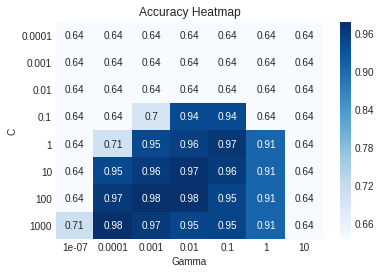

In [15]:
y = df['diagnosis']
X = StandardScaler().fit_transform(df.loc[:, min_overlaps])
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.33, random_state = 12082019)

estimate_cv = GridSearchCV(SVC(kernel='rbf'), params, cv=10)
estimate_cv_result = estimate_cv.fit(X_train, y_train)

rows = len(params['C'])
cols = len(params['gamma'])

cv_params = estimate_cv_result.cv_results_['mean_test_score'].reshape(rows, cols)
sns.heatmap(cv_params, annot=True, xticklabels=params['gamma'], yticklabels=params['C'], cmap='Blues');
plt.xlabel('Gamma');
plt.ylabel('C');
plt.title('Accuracy Heatmap');

best_estimator = estimate_cv_result.best_estimator_
best_C = best_estimator.C
best_Gamma = best_estimator.gamma

print('La mejor combinación de hiperparámetros es C = {} y Gamma = {}\n'.format(best_C, best_Gamma))

print('Classification Report | X_train\n')
y_hat = best_estimator.predict(X_train)
print(classification_report(y_train, y_hat))

print('Classification Report | X_test\n')
y_hat = best_estimator.predict(X_test)
print(classification_report(y_test, y_hat))

Aquí podemos ver que el hiperparámetro `C` es mayor y el `gamma` es más pequeño.

Comparado con el modelo anterior, este modelo tiene un peor desempeño para ambas clases, ya que para ambas clases el `f1-score` es menor.